In [1]:
# NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
import seaborn as sb
import nrrd
#from preprocessing_sequencing import preprocess_sequences as ps
from bg_atlasapi import BrainGlobeAtlas
#from final_processing import final_processing_functions as fpf
import ast
import yaml
from additional_functions import *
from scipy.ndimage import zoom


Load datasets

In [2]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
roi_dict = {}
sample_vol_and_regions = {}
parameters_dict = {}
barcodes_dict = {}
scaling_factor = 25 / 10  # since we need in 10um resolution, we need to convert 25um resolution registered cubelets to 10um
zoom_factors = (scaling_factor, scaling_factor, scaling_factor)
for mouse in mice:
    lcm_directory = pathlib.Path(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
    )
    # load datasets
    barcodes_across_sample = pd.read_pickle(
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl"
    )
    barcodes_dict[mouse] = barcodes_across_sample[barcodes_across_sample.sum(axis=1)>0]
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    not_in = [x for x in np.unique(ROI_3D) if x not in barcodes_across_sample.columns and x != 0]
    ROI_3D[np.isin(ROI_3D, not_in)] = 0
    sample_vol_and_regions[mouse] =pd.read_pickle(lcm_directory/'sample_vol_and_regions.pkl')
    parameters_dict[mouse] = load_parameters(directory=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/")
    mask = np.isin(ROI_3D, parameters_dict[mouse]['cortical_samples'])
    ROI_3D[~mask] = 0
    roi_dict[mouse] = zoom(ROI_3D, zoom=zoom_factors, order=0)
    # A1 = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    # barcodes_across_sample = barcodes_across_sample[barcodes_across_sample.idxmax(axis=1).isin(A1)]
# this is the path to where the ccf streamlines downloads is (so don't change when looking a different mice)
convert_to_flat_path = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration"
)
annotation_data = nrrd.read("/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/flatmap_butterfly.nrrd")
labels_df =  pd.read_csv(
            "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/labelDescription_ITKSNAPColor.txt",
            header=None,
            sep="\s+",
            index_col=0
        )
labels_df.columns = ["r", "g", "b", "x0", "x1", "x2", "acronym"]
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path / "flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path / "labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere="right_for_both",
    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere="flatmap_butterfly",
)
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path / "flatmap_butterfly.h5",
    # Specify our streamline file
    convert_to_flat_path / "surface_paths_10_v3.h5",
    # Specify that we want to project both hemispheres
    hemisphere="both",
    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere="flatmap_butterfly",
)

ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]

loading path information


100%|██████████| 1016/1016 [00:06<00:00, 163.77it/s]
/tmp/ipykernel_42330/163257608.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)


Plot with SSp detail boundary

/tmp/ipykernel_27177/2130869609.py:20: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
/tmp/ipykernel_27177/2130869609.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


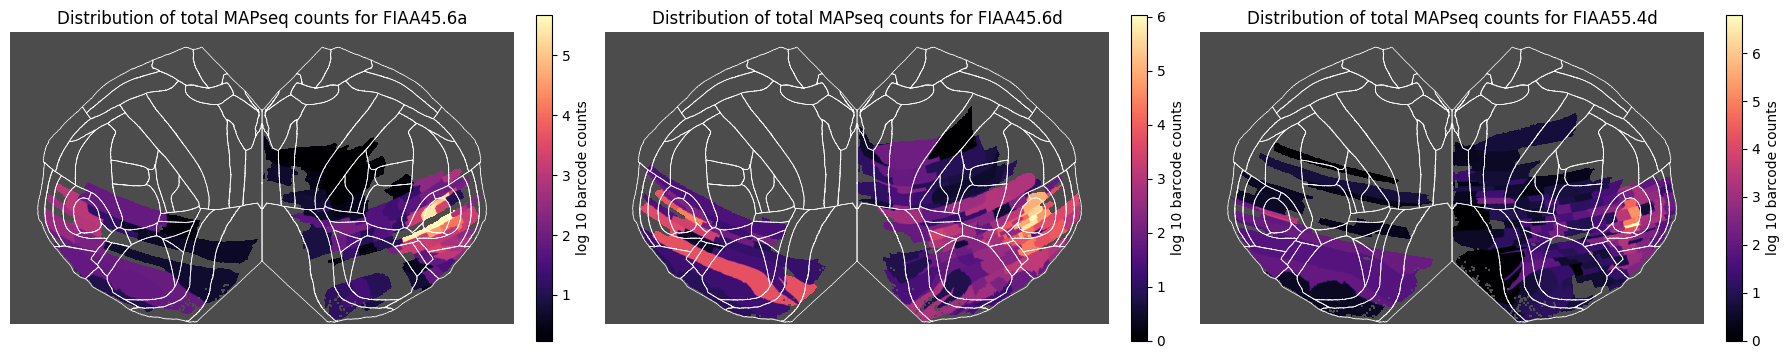

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
for ax, mouse in zip(axes, mice):
    # Access barcodes across sample for the current mouse
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    
    # Fill the barcode matrix
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    
    # Calculate total counts and set zero values to -1
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T

    # Set up the color map
    cmap = plt.cm.get_cmap("magma").copy()
    cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

    # Plot the heatmap on the current axis
    im = ax.imshow(new_mat, cmap=cmap)
    ax.axis("off")
    
    # Add color bar to each subplot
    fig.colorbar(im, ax=ax, label="log 10 barcode counts", fraction=0.03, pad=0.04)

    # Plot the boundaries for each side
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    # Set the title for each subplot
    ax.set_title(f"Distribution of total MAPseq counts for {mouse}")

# Adjust layout to make space between subplots
plt.tight_layout()

Plot without SSp detail boundary

/tmp/ipykernel_42330/635403602.py:31: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
/tmp/ipykernel_42330/635403602.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


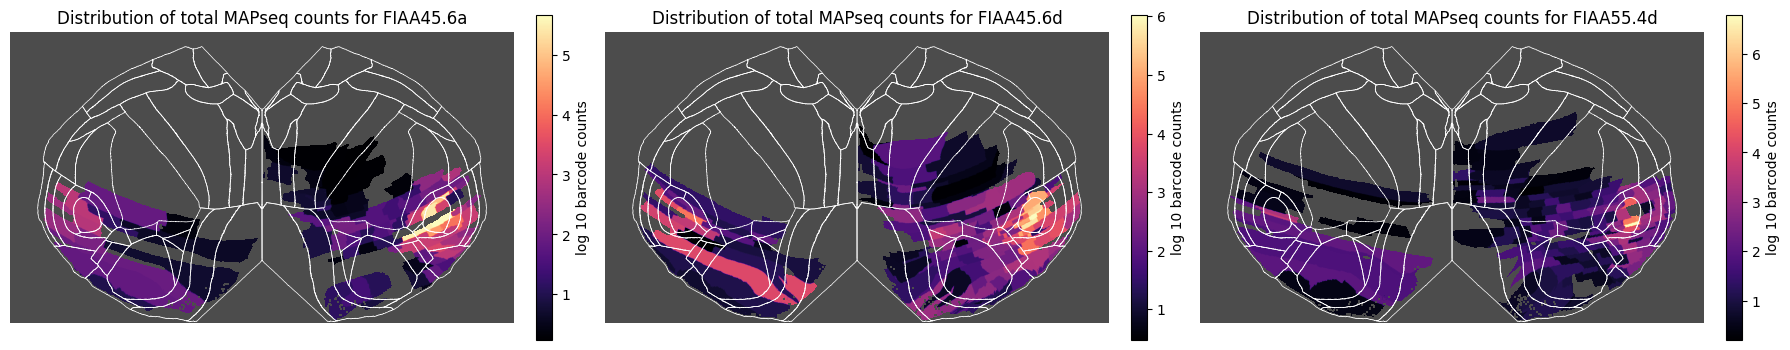

In [4]:
SSp_regions = []
# SSp_all_coords ={}
for key in bf_left_boundaries.keys():
    if 'SSp' in key:
        SSp_regions.append(str(key))
        # coords = bf_left_boundaries[key]
        # SSp_all_coords[key] = coords
new_left_bound_dict = {key: value for key, value in bf_left_boundaries.items() if key not in SSp_regions}    
new_right_bound_dict = {key: value for key, value in bf_right_boundaries.items() if key not in SSp_regions}    

all_mice_flat = {}
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
for ax, mouse in zip(axes, mice):
    # Access barcodes across sample for the current mouse
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    
    # Fill the barcode matrix
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    
    # Calculate total counts and set zero values to -1
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
    all_mice_flat[mouse] = new_mat
    # Set up the color map
    cmap = plt.cm.get_cmap("magma").copy()
    cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

    # Plot the heatmap on the current axis
    im = ax.imshow(new_mat, cmap=cmap)
    ax.axis("off")
    
    # Add color bar to each subplot
    fig.colorbar(im, ax=ax, label="log 10 barcode counts", fraction=0.03, pad=0.04)

    # Plot the boundaries for each side
    for k, boundary_coords in new_left_bound_dict.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in new_right_bound_dict.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    # Set the title for each subplot
    ax.set_title(f"Distribution of total MAPseq counts for {mouse}")

# Adjust layout to make space between subplots
plt.tight_layout()
plt.show()
# Save the figure with three subplots
#plt.savefig("/camp/lab/znamenskiyp/home/shared/code/MAPseq_processing/figs/MAPseq_bulk_counts.png", bbox_inches='tight', dpi=300)

# Clear the current figure to avoid overwriting or displaying
#plt.clf()

/tmp/ipykernel_42330/59065787.py:31: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
/tmp/ipykernel_42330/59065787.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


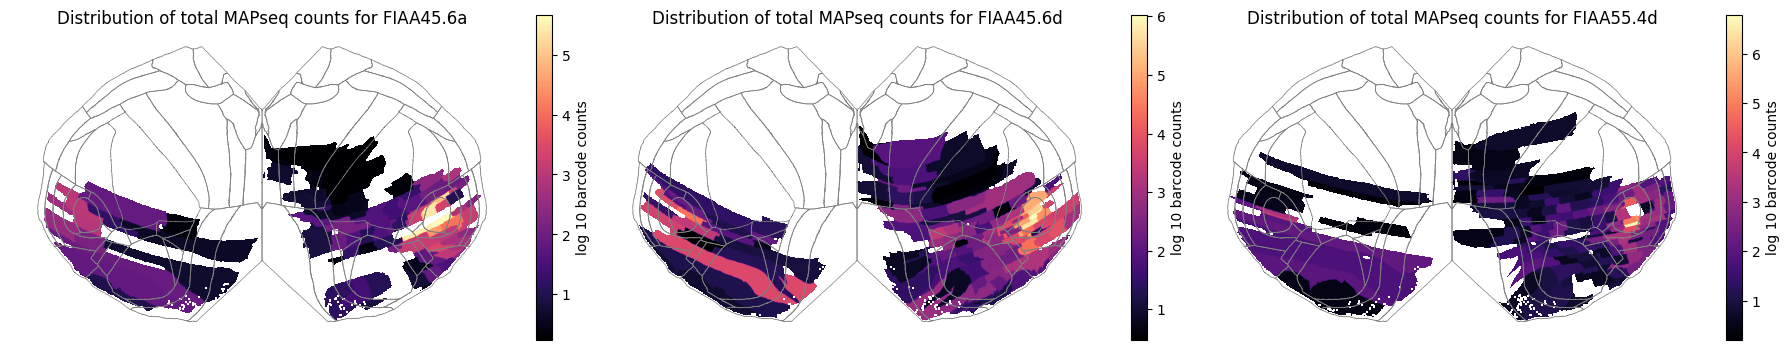

In [5]:
SSp_regions = []
# SSp_all_coords ={}
for key in bf_left_boundaries.keys():
    if 'SSp' in key:
        SSp_regions.append(str(key))
        # coords = bf_left_boundaries[key]
        # SSp_all_coords[key] = coords
new_left_bound_dict = {key: value for key, value in bf_left_boundaries.items() if key not in SSp_regions}    
new_right_bound_dict = {key: value for key, value in bf_right_boundaries.items() if key not in SSp_regions}    

all_mice_flat = {}
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
for ax, mouse in zip(axes, mice):
    # Access barcodes across sample for the current mouse
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    
    # Fill the barcode matrix
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    
    # Calculate total counts and set zero values to -1
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
    all_mice_flat[mouse] = new_mat
    # Set up the color map
    cmap = plt.cm.get_cmap("magma").copy()
    cmap.set_bad(color=[1, 1, 1, 1])  # Set NaN values as grey

    # Plot the heatmap on the current axis
    im = ax.imshow(new_mat, cmap=cmap)
    ax.axis("off")
    
    # Add color bar to each subplot
    fig.colorbar(im, ax=ax, label="log 10 barcode counts", fraction=0.03, pad=0.04)

    # Plot the boundaries for each side
    for k, boundary_coords in new_left_bound_dict.items():
        ax.plot(*boundary_coords.T, c="grey", lw=0.5)
    for k, boundary_coords in new_right_bound_dict.items():
        ax.plot(*boundary_coords.T, c="grey", lw=0.5)

    # Set the title for each subplot
    ax.set_title(f"Distribution of total MAPseq counts for {mouse}")

# Adjust layout to make space between subplots
plt.tight_layout()
plt.show()
# Save the figure with three subplots
#plt.savefig("/camp/lab/znamenskiyp/home/shared/code/MAPseq_processing/figs/MAPseq_bulk_counts.png", bbox_inches='tight', dpi=300)

# Clear the current figure to avoid overwriting or displaying
#plt.clf()

Now let's plot the average projection strength, not including soma samples

In [12]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
roi_dict = {}
sample_vol_and_regions = {}
parameters_dict = {}
barcodes_dict = {}
scaling_factor = 25 / 10  # since we need in 10um resolution, we need to convert 25um resolution registered cubelets to 10um
zoom_factors = (scaling_factor, scaling_factor, scaling_factor)
for mouse in mice:
    lcm_directory = pathlib.Path(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
    )
    # load datasets
    barcodes_across_sample = pd.read_pickle(
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/A1_barcodes_thresholded.pkl"
    )
    barcodes_dict[mouse] = barcodes_across_sample[barcodes_across_sample.sum(axis=1)>0]
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    not_in = [x for x in np.unique(ROI_3D) if x not in barcodes_across_sample.columns and x != 0]
    ROI_3D[np.isin(ROI_3D, not_in)] = 0
    sample_vol_and_regions[mouse] =pd.read_pickle(lcm_directory/'sample_vol_and_regions.pkl')
    parameters_dict[mouse] = load_parameters(directory=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/")
    mask = np.isin(ROI_3D, parameters_dict[mouse]['cortical_samples'])
    ROI_3D[~mask] = 0
    roi_dict[mouse] = zoom(ROI_3D, zoom=zoom_factors, order=0)
    # A1 = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    # barcodes_across_sample = barcodes_across_sample[barcodes_across_sample.idxmax(axis=1).isin(A1)]
# this is the path to where the ccf streamlines downloads is (so don't change when looking a different mice)
convert_to_flat_path = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration"
)
annotation_data = nrrd.read("/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/flatmap_butterfly.nrrd")
labels_df =  pd.read_csv(
            "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/labelDescription_ITKSNAPColor.txt",
            header=None,
            sep="\s+",
            index_col=0
        )
labels_df.columns = ["r", "g", "b", "x0", "x1", "x2", "acronym"]
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path / "flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path / "labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere="right_for_both",
    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere="flatmap_butterfly",
)
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path / "flatmap_butterfly.h5",
    # Specify our streamline file
    convert_to_flat_path / "surface_paths_10_v3.h5",
    # Specify that we want to project both hemispheres
    hemisphere="both",
    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere="flatmap_butterfly",
)

ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]

loading path information


100%|██████████| 1016/1016 [00:06<00:00, 164.06it/s]
/tmp/ipykernel_42330/304543518.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)


In [ ]:
# for key in all_mice_flat:
#     all_mice_flat[key] = np.where(np.isinf(all_mice_flat[key]), np.nan, all_mice_flat[key])

# # Stack the arrays along a new axis
# stacked_arrays = np.stack(list(all_mice_flat.values()), axis=2)

# # Compute the mean, ignoring NaN values
# mean_array = np.nanmean(stacked_arrays, axis=2)
# fig, ax = plt.subplots(1, figsize=(6, 6)) 
# cmap = plt.cm.get_cmap("magma").copy()
# cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

# # Plot the heatmap on the current axis
# im = ax.imshow(mean_array, cmap=cmap)
# ax.axis("off")

# # Add color bar to each subplot
# fig.colorbar(im, ax=ax, label="log 10 barcode counts", fraction=0.03, pad=0.04)

# # Plot the boundaries for each side
# for k, boundary_coords in new_left_bound_dict.items():
#     ax.plot(*boundary_coords.T, c="white", lw=0.5)
# for k, boundary_coords in new_right_bound_dict.items():
#     ax.plot(*boundary_coords.T, c="white", lw=0.5)

# # Set the title for each subplot
# ax.set_title(f"Distribution of total MAPseq counts for {mouse}")

# # Adjust layout to make space between subplots
# plt.tight_layout()
# plt.show()


In [13]:
for mouse in mice:
    # Access barcodes across sample for the current mouse
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    
    
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    lcm_directory = pathlib.Path(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
    )
    sample_vol_and_regions =pd.read_pickle(lcm_directory/'sample_vol_and_regions.pkl')
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = np.nan
    for i in range(total_counts.shape[0]):
        if i in barcodes_across_sample.columns:
            # Get the corresponding volume from sample_vol_and_regions
            volume = sample_vol_and_regions[sample_vol_and_regions['ROI Number'] == i]['Volume (um^3)'].values[0]
            
            # Divide the value in total_counts by the volume
            total_counts[i] /= volume
    new_mat = total_counts[ROI_projection_max.astype(int)].T
    all_mice_flat[mouse] = new_mat
    
for key in all_mice_flat:
    all_mice_flat[key] = np.where(np.isinf(all_mice_flat[key]), np.nan, all_mice_flat[key])
stacked_arrays = np.stack(list(all_mice_flat.values()), axis=2)
mean_array = np.nanmean(stacked_arrays, axis=2)
# fig, ax = plt.subplots(1, figsize=(6, 6)) 
# cmap = plt.cm.get_cmap("magma").copy()
# cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

# # Plot the heatmap on the current axis
# im = ax.imshow(mean_array, cmap=cmap, norm=LogNorm())
# ax.axis("off")

# # Add color bar to each subplot
# fig.colorbar(im, ax=ax, label="normalised counts/µm³", fraction=0.03, pad=0.04)

# # Plot the boundaries for each side
# for k, boundary_coords in new_left_bound_dict.items():
#     ax.plot(*boundary_coords.T, c="white", lw=0.5)
# for k, boundary_coords in new_right_bound_dict.items():
#     ax.plot(*boundary_coords.T, c="white", lw=0.5)

# # Set the title for each subplot
# ax.set_title(f"Mean projection strength")

# # Adjust layout to make space between subplots
# plt.tight_layout()
# plt.show()


/tmp/ipykernel_42330/185421089.py:34: RuntimeWarning: Mean of empty slice
  mean_array = np.nanmean(stacked_arrays, axis=2)


In [9]:

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
# highlight AUDp in red
zoom_factors = (scaling_factor, scaling_factor, scaling_factor)
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
empty_frame = np.zeros((528, 320, 456))
x_midpoint = empty_frame.shape[2] // 2
contra_mask = np.zeros(empty_frame.shape, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1
structure_tree = mcc.get_structure_tree()
structure = structure_tree.get_structures_by_acronym(['AUDp'])
structure_id = structure[0]['id']
mask = rsp.make_structure_mask([structure_id], direct_only=False)
mask = mask*contra_mask
empty_frame[np.where(mask==1)] = 1
barcode_3D = zoom(empty_frame, zoom=zoom_factors, order=0)
projection_max = proj_top.project_volume(barcode_3D).T

/tmp/ipykernel_42330/3582482394.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


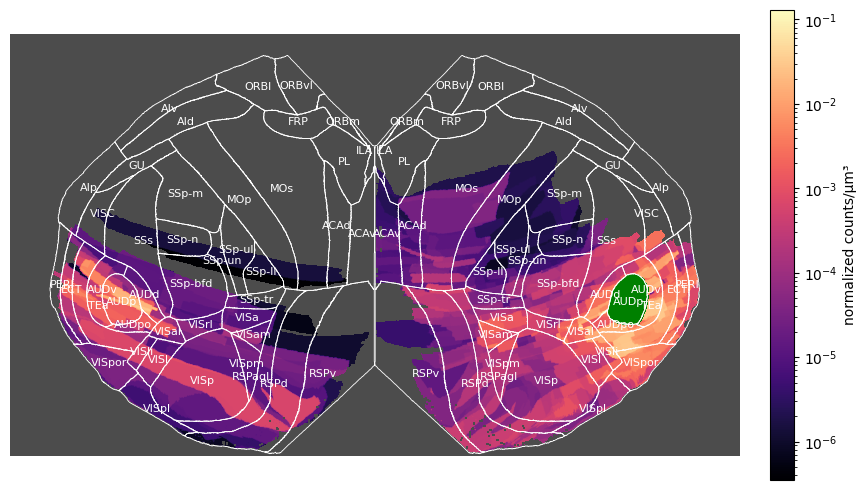

In [14]:
fig, ax = plt.subplots(1, figsize=(8, 8))
cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

# Plot the heatmap on the current axis
im = ax.imshow(mean_array, cmap=cmap, norm=LogNorm(), aspect='equal')
ax.axis("off")

# Get the shape of the mean_array (height, width)
height, width = mean_array.shape

# Further zoom into the bottom-right corner
# Adjust limits to zoom further into the bottom-right corner
#ax.set_xlim(1480, 1980)  # Crop to a smaller right section of the x-axis
#ax.set_ylim(1300, 850)  # Crop to a smaller bottom section of the y-axis

# Add color bar to each subplot
fig.colorbar(im, ax=ax, label="normalized counts/µm³", fraction=0.03, pad=0.04)

red_cmap = ListedColormap(['none', 'green'])  # 'none' makes the 0 values fully transparent

# Plot the red overlay only where projection_max == 1
ax.imshow(projection_max, cmap=red_cmap, vmin=0, vmax=1)
for k, boundary_coords in bf_left_boundaries.items():
    # Plot the boundary
    ax.plot(*boundary_coords.T, c="white", lw=0.6)
    
    # Calculate the centroid (center) for the text placement
    centroid_x = np.mean(boundary_coords[:, 0])
    centroid_y = np.mean(boundary_coords[:, 1])
    
    # Add the name of the key at the centroid
    ax.text(centroid_x, centroid_y, k, color="white", fontsize=8, ha='center', va='center')

for k, boundary_coords in bf_right_boundaries.items():
    # Plot the boundary
    ax.plot(*boundary_coords.T, c="white", lw=0.6)
    
    # Calculate the centroid (center) for the text placement
    centroid_x = np.mean(boundary_coords[:, 0])
    centroid_y = np.mean(boundary_coords[:, 1])
    
    # Add the name of the key at the centroid
    ax.text(centroid_x, centroid_y, k, color="white", fontsize=8, ha='center', va='center')

# Adjust layout to maximize plot size
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
# Show the plot
plt.show()


/tmp/ipykernel_42330/2590408136.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


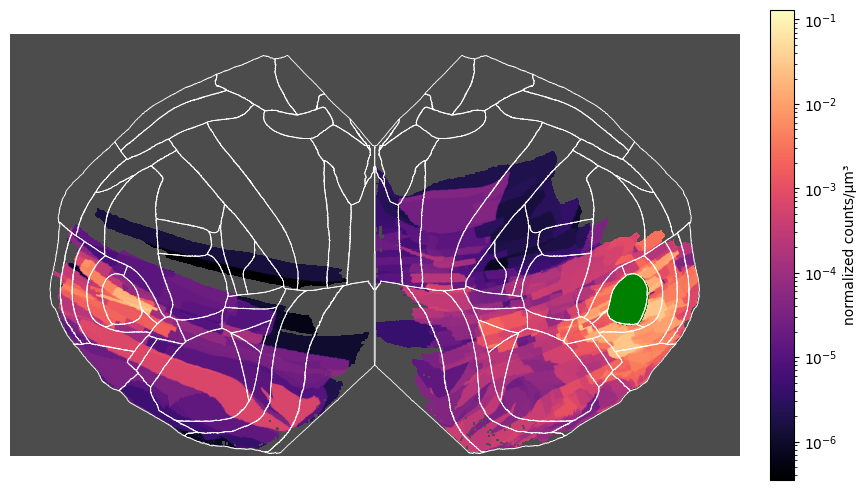

In [15]:
fig, ax = plt.subplots(1, figsize=(8, 8))
cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

# Plot the heatmap on the current axis
im = ax.imshow(mean_array, cmap=cmap, norm=LogNorm(), aspect='equal')
ax.axis("off")

# Get the shape of the mean_array (height, width)
height, width = mean_array.shape

# Further zoom into the bottom-right corner
# Adjust limits to zoom further into the bottom-right corner
#ax.set_xlim(1480, 1980)  # Crop to a smaller right section of the x-axis
#ax.set_ylim(1300, 850)  # Crop to a smaller bottom section of the y-axis

# Add color bar to each subplot
fig.colorbar(im, ax=ax, label="normalized counts/µm³", fraction=0.03, pad=0.04)

red_cmap = ListedColormap(['none', 'green'])  # 'none' makes the 0 values fully transparent

# Plot the red overlay only where projection_max == 1
ax.imshow(projection_max, cmap=red_cmap, vmin=0, vmax=1)
for k, boundary_coords in bf_left_boundaries.items():
    # Plot the boundary
    ax.plot(*boundary_coords.T, c="white", lw=0.6)
    
    # Calculate the centroid (center) for the text placement
    centroid_x = np.mean(boundary_coords[:, 0])
    centroid_y = np.mean(boundary_coords[:, 1])
    
    # Add the name of the key at the centroid
    #ax.text(centroid_x, centroid_y, k, color="white", fontsize=8, ha='center', va='center')

for k, boundary_coords in bf_right_boundaries.items():
    # Plot the boundary
    ax.plot(*boundary_coords.T, c="white", lw=0.6)
    
    # Calculate the centroid (center) for the text placement
    centroid_x = np.mean(boundary_coords[:, 0])
    centroid_y = np.mean(boundary_coords[:, 1])
    
    # Add the name of the key at the centroid
    #ax.text(centroid_x, centroid_y, k, color="white", fontsize=8, ha='center', va='center')

# Adjust layout to maximize plot size
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
# Show the plot
plt.show()


/tmp/ipykernel_42330/414228519.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


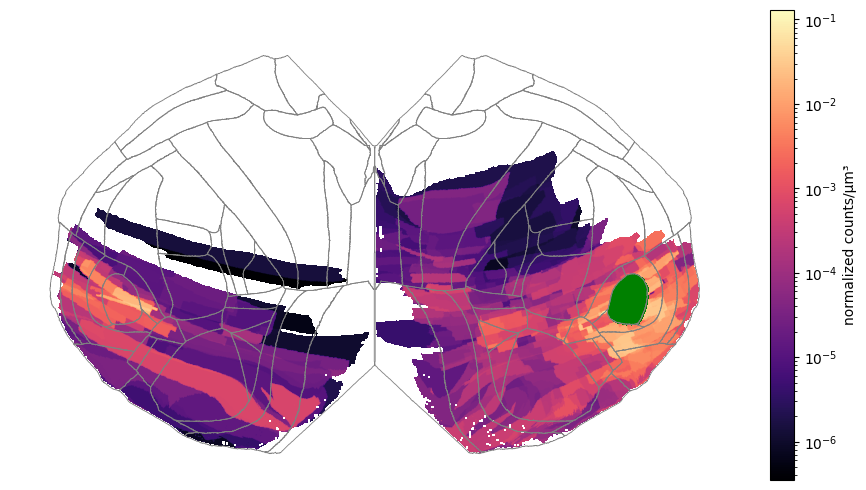

In [16]:
fig, ax = plt.subplots(1, figsize=(8, 8))
cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[1, 1, 1, 1])  # Set NaN values as grey

# Plot the heatmap on the current axis
im = ax.imshow(mean_array, cmap=cmap, norm=LogNorm(), aspect='equal')
ax.axis("off")

# Get the shape of the mean_array (height, width)
height, width = mean_array.shape

# Further zoom into the bottom-right corner
# Adjust limits to zoom further into the bottom-right corner
#ax.set_xlim(1480, 1980)  # Crop to a smaller right section of the x-axis
#ax.set_ylim(1300, 850)  # Crop to a smaller bottom section of the y-axis

# Add color bar to each subplot
fig.colorbar(im, ax=ax, label="normalized counts/µm³", fraction=0.03, pad=0.04)

red_cmap = ListedColormap(['none', 'green'])  # 'none' makes the 0 values fully transparent

# Plot the red overlay only where projection_max == 1
ax.imshow(projection_max, cmap=red_cmap, vmin=0, vmax=1)
for k, boundary_coords in bf_left_boundaries.items():
    # Plot the boundary
    ax.plot(*boundary_coords.T, c="grey", lw=0.6)
    
    # Calculate the centroid (center) for the text placement
    centroid_x = np.mean(boundary_coords[:, 0])
    centroid_y = np.mean(boundary_coords[:, 1])
    
    # Add the name of the key at the centroid
    #ax.text(centroid_x, centroid_y, k, color="white", fontsize=8, ha='center', va='center')

for k, boundary_coords in bf_right_boundaries.items():
    # Plot the boundary
    ax.plot(*boundary_coords.T, c="grey", lw=0.6)
    
    # Calculate the centroid (center) for the text placement
    centroid_x = np.mean(boundary_coords[:, 0])
    centroid_y = np.mean(boundary_coords[:, 1])
    
    # Add the name of the key at the centroid
    #ax.text(centroid_x, centroid_y, k, color="white", fontsize=8, ha='center', va='center')

# Adjust layout to maximize plot size
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
# Show the plot
plt.show()


Zoomed in to visual areas

/tmp/ipykernel_27177/2157454646.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


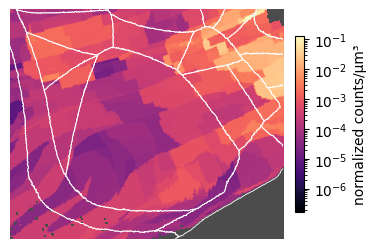

In [25]:
fig, ax = plt.subplots(1, figsize=(3, 3))
cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

# Plot the heatmap on the current axis
im = ax.imshow(mean_array, cmap=cmap, norm=LogNorm(), aspect='equal')
ax.axis("off")
overlay = np.zeros_like(projection_max, dtype=np.float32)
overlay[np.where(projection_max == 1)] = 1  # Mark the areas where projection_max is 1

# Use a transparent red overlay for the regi
# Get the shape of the mean_array (height, width)
height, width = mean_array.shape

# Further zoom into the bottom-right corner
# Adjust limits to zoom further into the bottom-right corner
ax.set_xlim(1480, 1980)  # Crop to a smaller right section of the x-axis
ax.set_ylim(1300, 880)  # Crop to a smaller bottom section of the y-axis

# Add color bar to each subplot
fig.colorbar(im, ax=ax, label="normalized counts/µm³", fraction=0.03, pad=0.04)

for k, boundary_coords in bf_left_boundaries.items():
    # Plot the boundary
    ax.plot(*boundary_coords.T, c="white", lw=0.6)
    
    # Calculate the centroid (center) for the text placement
    centroid_x = np.mean(boundary_coords[:, 0])
    centroid_y = np.mean(boundary_coords[:, 1])
    
    # Add the name of the key at the centroid
    #ax.text(centroid_x, centroid_y, k, color="white", fontsize=8, ha='center', va='center')

for k, boundary_coords in bf_right_boundaries.items():
    # Plot the boundary
    ax.plot(*boundary_coords.T, c="white", lw=0.6)
    
    # Calculate the centroid (center) for the text placement
    centroid_x = np.mean(boundary_coords[:, 0])
    centroid_y = np.mean(boundary_coords[:, 1])
    
    # Add the name of the key at the centroid
    #ax.text(centroid_x, centroid_y, k, color="white", fontsize=8, ha='center', va='center')
#look = ax.imshow(projection_max, cmap='Blues', aspect='equal')
# Adjust layout to maximize plot size
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
# Show the plot
plt.show()


/tmp/ipykernel_27177/134902602.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


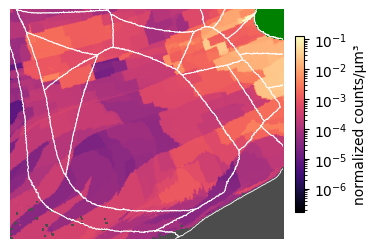

In [36]:
fig, ax = plt.subplots(1, figsize=(3, 3))
cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

# Plot the heatmap on the current axis
im = ax.imshow(mean_array, cmap=cmap, norm=LogNorm(), aspect='equal')
ax.axis("off")
overlay = np.zeros_like(projection_max, dtype=np.float32)
overlay[np.where(projection_max == 1)] = 1  # Mark the areas where projection_max is 1

# Use a transparent red overlay for the regi
# Get the shape of the mean_array (height, width)
height, width = mean_array.shape

# Further zoom into the bottom-right corner
# Adjust limits to zoom further into the bottom-right corner
ax.set_xlim(1480, 1980)  # Crop to a smaller right section of the x-axis
ax.set_ylim(1300, 880)  # Crop to a smaller bottom section of the y-axis

# Add color bar to each subplot
fig.colorbar(im, ax=ax, label="normalized counts/µm³", fraction=0.03, pad=0.04)
red_cmap = ListedColormap(['none', 'green'])  # 'none' makes the 0 values fully transparent

# Plot the red overlay only where projection_max == 1
ax.imshow(projection_max, cmap=red_cmap, vmin=0, vmax=1)
for k, boundary_coords in bf_left_boundaries.items():
    # Plot the boundary
    ax.plot(*boundary_coords.T, c="white", lw=0.6)
    
    # Calculate the centroid (center) for the text placement
    centroid_x = np.mean(boundary_coords[:, 0])
    centroid_y = np.mean(boundary_coords[:, 1])
    
    # Add the name of the key at the centroid
    #ax.text(centroid_x, centroid_y, k, color="white", fontsize=8, ha='center', va='center')

for k, boundary_coords in bf_right_boundaries.items():
    # Plot the boundary
    ax.plot(*boundary_coords.T, c="white", lw=0.6)
    
    # Calculate the centroid (center) for the text placement
    centroid_x = np.mean(boundary_coords[:, 0])
    centroid_y = np.mean(boundary_coords[:, 1])
    
    # Add the name of the key at the centroid
    #ax.text(centroid_x, centroid_y, k, color="white", fontsize=8, ha='center', va='center')
#look = ax.imshow(projection_max, cmap='Blues', aspect='equal')
# Adjust layout to maximize plot size
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
# Show the plot
plt.show()


/tmp/ipykernel_27177/3278144274.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


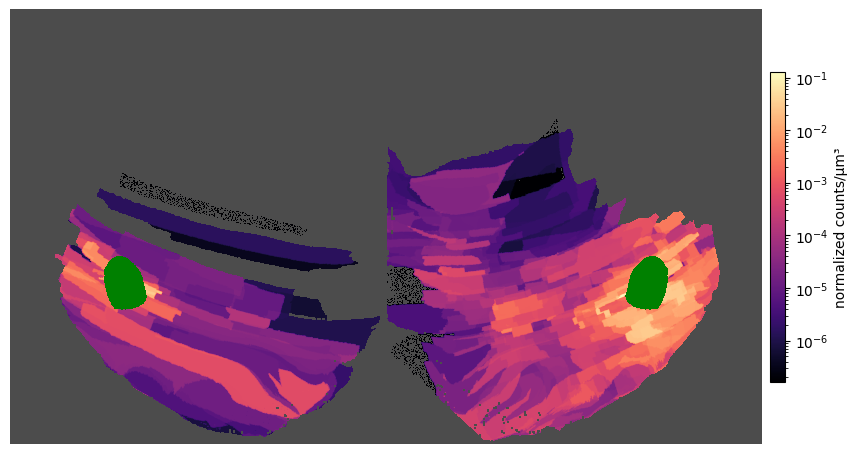

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm, ListedColormap

# Assuming mean_array and projection_max are defined

fig, ax = plt.subplots(figsize=(10, 10))

# Base heatmap using mean_array
cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

im = ax.imshow(mean_array, cmap=cmap, norm=LogNorm(), aspect='auto')

# Create a custom colormap for the overlay where 0 is fully transparent, and 1 is red
red_cmap = ListedColormap(['none', 'green'])  # 'none' makes the 0 values fully transparent

# Plot the red overlay only where projection_max == 1
ax.imshow(projection_max, cmap=red_cmap, vmin=0, vmax=1)

# Add color bar for the base heatmap
fig.colorbar(im, ax=ax, label="normalized counts/µm³", fraction=0.02, pad=0.01)

# Remove axis labels and ticks
ax.axis("off")

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Assuming mean_array, bf_left_boundaries, and bf_right_boundaries are defined

fig, ax = plt.subplots(figsize=(10, 10))  # Increase figure size

cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

# Plot the heatmap on the current axis
im = ax.imshow(mean_array, cmap=cmap, norm=LogNorm(), aspect='auto')

# Remove axis lines and ticks
ax.axis("off")

# Get the shape of the mean_array (height, width)
height, width = mean_array.shape

# Crop further into the bottom-right quarter of the heatmap
ax.set_xlim(3 * width // 4, width)  # Crop to the bottom-right x


In [ ]:
new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T

In [ ]:
hull = ConvexHull(combined_boundary)

# Plot the result
plt.plot(combined_boundary[:, 0], combined_boundary[:, 1], 'o')
for simplex in hull.simplices:
    plt.plot(combined_boundary[simplex, 0], combined_boundary[simplex, 1], 'k-')

plt.title('Convex Hull Boundary')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()